## Merging the regional nc file to global ones for ensemble members and also deterministic hourly values



In [ ]:
import os
import requests
import base64
import hashlib
import glob
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import click


def merging_EM_ERATH_ensmebles  (variables = ['prcp','tdew','tmean','trange'],
                                 regions = ['Asia','Europe','Africa',\
                                            'NorthAmerica','Oceania','SouthAmerica'],
                                 years = ['1950','1951','1952','1953','1954',\
                                          '1955','1956','1957','1958','1959',\
                                          '1960','1961','1962','1963','1964',\
                                          '1965','1966','1967','1968','1969',\
                                          '1970','1971','1972','1973','1974',\
                                          '1975','1976','1977','1978','1979',\
                                          '1980','1981','1982','1983','1984',\
                                          '1985','1986','1987','1988','1989',\
                                          '1990','1991','1992','1993','1994',\
                                          '1995','1996','1997','1998','1999',\
                                          '2000','2001','2002','2003','2004',\
                                          '2005','2006','2007','2008','2009',\
                                          '2010','2011','2012','2013','2014',\
                                          '2015','2016','2017','2018','2019'],
                                 months = ['01','02','03','04','05','06',\
                                           '07','08','09','10','11','12'],
                                 ensembles = ['001','002','003','004','005',\
                                              '006','007','008','009','010',\
                                              '011','012','013','014','015',\
                                              '016','017','018','019','020',\
                                              '021','022','023','024','025'],
                                 root_save = '../EM_Earth_v1/'):
    
    
    for year in years:

        for month in months:

            for variable in variables:
                
                # file_name
                file_name = root_save+'deterministic_raw_daily/'+variable+'/'+\
                'EM_Earth_deterministic_daily_'+variable+'_'+year+month+'.nc'
                
                #
                if os.path.isfile(file_name):
                
                    # open dataset
                    ds_global = xr.open_dataset(file_name)
                    #print(ds_global.lon[0:3])

                    # reorganize the variables to time, lat, lon
                    ds_global = ds_global.transpose('time', 'lat', 'lon')

                    mask_sum ={}
                    # replace the varibales with 0.00
                    for v in ds_global.data_vars:
                        ds_global [v][:] = 0.00
                        mask_sum[v] = np.zeros([1800, 3600])

                    # loop over the ensembles
                    for ensemble in ensembles:

                        #  read the files
                        file_names = root_save+'probabilistic_daily/'+variable+'/*/'+\
                                               year+month+'/*'+ensemble+'.nc'
                        file_names = glob.glob(file_names)

                        if file_names:

                            #
                            for file_name in file_names:
                                # print(file_name)
                                ds = xr.open_dataset(file_name)
                                # print(ds.data_vars)
                                ds = ds.transpose('time', 'lat', 'lon') # making sure the order

                                if ds.lon.values.max() > 180:
                                    # Asia
                                    ds1 = ds.sel(lon=slice(None, 179.975))
                                    ds2 = ds.sel(lon=slice(179.975, None))
                                    ds2['lon'] = ds2['lon'] - 360
                                    ds_global, mask_sum = fill_cont_to_globe(ds1, ds_global, mask_sum)
                                    ds_global, mask_sum = fill_cont_to_globe(ds2, ds_global, mask_sum)
                                elif ds.lon.values.min() < -180:
                                    # North America
                                    ds1 = ds.sel(lon=slice(None, -179.975))
                                    ds2 = ds.sel(lon=slice(-179.975, None))
                                    ds1['lon'] = ds1['lon'] + 360
                                    ds_global, mask_sum = fill_cont_to_globe(ds1, ds_global, mask_sum)
                                    ds_global, mask_sum = fill_cont_to_globe(ds2, ds_global, mask_sum)
                                else:
                                    ds_global, mask_sum = fill_cont_to_globe(ds , ds_global, mask_sum)


                            file_name_save = 'EM_Earth_probabilistic_daily_'+variable+'_global_'+\
                                        year+month+'_'+ensemble+'.nc'
                            folder_name = root_save+'probabilistic_daily_global/'+variable+'/'+\
                                        year+month+'/'
                            if not os.path.isdir(folder_name):
                                os.makedirs(folder_name)

                            for name, value in ds_global.items():
                                for t in range(value.shape[0]):
                                    temp = np.array(value[t,:,:]) / mask_sum[name]
                                    temp[mask_sum[name] == 0] = -9999
                                    value[t, :, :] = temp
                                ds_global[name] = value

                            # print(file_name_save)

                            os.system('rm '+folder_name+file_name_save)

                            encoding = {}
                            for var in ds_global.data_vars:
                                encoding[var] = {'_FillValue': -9999., 'zlib': True, 'complevel': 4}

                            ds_global.to_netcdf(folder_name+file_name_save, unlimited_dims='time', encoding=encoding)
                            
                            #
                            test_merging (file_names, folder_name+file_name_save,  year, month, variable)
                            
                            # close
                            ds.close()
                            ds1.close()
                            ds2.close()
                            ds_global.close()
                            

def merging_EM_ERATH_deterministic  (variables = ['prcp','tdew','tmean'],
                                     regions = ['Asia','Europe','Africa',\
                                                'NorthAmerica','Oceania','SouthAmerica'],
                                     years = ['1950','1951','1952','1953','1954',\
                                              '1955','1956','1957','1958','1959',\
                                              '1960','1961','1962','1963','1964',\
                                              '1965','1966','1967','1968','1969',\
                                              '1970','1971','1972','1973','1974',\
                                              '1975','1976','1977','1978','1979',\
                                              '1980','1981','1982','1983','1984',\
                                              '1985','1986','1987','1988','1989',\
                                              '1990','1991','1992','1993','1994',\
                                              '1995','1996','1997','1998','1999',\
                                              '2000','2001','2002','2003','2004',\
                                              '2005','2006','2007','2008','2009',\
                                              '2010','2011','2012','2013','2014',\
                                              '2015','2016','2017','2018','2019'],
                                     months = ['01','02','03','04','05','06',\
                                               '07','08','09','10','11','12'],
                                     root_save = '../EM_Earth_v1/'):
    
    
    for year in years:

        for month in months:

            for variable in variables:
                
                # file_name
                file_name_global = root_save+'deterministic_raw_daily/'+variable+'/'+\
                'EM_Earth_deterministic_daily_'+variable+'_'+year+month+'.nc'
                file_name_times = glob.glob(root_save+'deterministic_hourly/'+variable+'/*/'+\
                'EM_Earth_deterministic_hourly_*_'+year+month+'.nc')
                
                #
                if os.path.isfile(file_name_global) and file_name_times:
                    
                    
                
                    # open dataset
                    ds_global = xr.open_dataset(file_name_global)
                    ds_time = xr.open_dataset(file_name_times[0])

                    # go from daily to hourly values
                    ds_temp = ds_global.copy()
                    temp = ds_temp['time'].copy()
                    ds_temp = ds_temp.drop(labels='time')
                    ds_temp['time'] = temp + np.timedelta64(23, 'h')
                    ds_temp = ds_temp.isel(time=[-2,-1])
                    ds_global = xr.merge([ds_global, ds_temp])
                    ds_global = ds_global.resample(time='1H').pad()
                    ds_global = ds_global.drop(labels='time')
                    ds_global['time'] = ds_time['time']
                    
                    # reorganize the variables to time, lat, lon
                    ds_global = ds_global.transpose('time', 'lat', 'lon')

                    mask_sum ={}
                    # replace the varibales with 0.00
                    for v in ds_global.data_vars:
                        ds_global [v][:] = 0.00
                        mask_sum[v] = np.zeros([1800, 3600])
                        
                    #  read the files
                    file_names = root_save+'deterministic_hourly/'+variable+'/*/*'+\
                                           year+month+'*.nc'
                    file_names = glob.glob(file_names)
                    
                    file_names = file_names[0:2]
                    
                    
                    if file_names:
                        
                        file_names = file_names

                        #
                        for file_name in file_names:
                            
                            ds = xr.open_dataset(file_name)
                            
                            ds = ds.transpose('time', 'lat', 'lon') # making sure the order

                            if ds.lon.values.max() > 180:
                                # Asia
                                ds1 = ds.sel(lon=slice(None, 179.975))
                                ds2 = ds.sel(lon=slice(179.975, None))
                                ds2['lon'] = ds2['lon'] - 360
                                ds_global, mask_sum = fill_cont_to_globe(ds1, ds_global, mask_sum)
                                ds_global, mask_sum = fill_cont_to_globe(ds2, ds_global, mask_sum)
                            elif ds.lon.values.min() < -180:
                                # North America
                                ds1 = ds.sel(lon=slice(None, -179.975))
                                ds2 = ds.sel(lon=slice(-179.975, None))
                                ds1['lon'] = ds1['lon'] + 360
                                ds_global, mask_sum = fill_cont_to_globe(ds1, ds_global, mask_sum)
                                ds_global, mask_sum = fill_cont_to_globe(ds2, ds_global, mask_sum)
                            else:
                                ds_global, mask_sum = fill_cont_to_globe(ds , ds_global, mask_sum)


                        file_name_save = 'EM_Earth_deterministic_hourly_'+variable+'_global_'+\
                                    year+month+'.nc'
                        folder_name = root_save+'deterministic_hourly_global/'+variable+'/'+\
                                    year+month+'/'
                        
                        if not os.path.isdir(folder_name):
                            os.makedirs(folder_name)
                            
                        
                        for name, value in ds_global.items():
                            for t in range(value.shape[0]):
                                temp = np.array(value[t,:,:]) / mask_sum[name]
                                temp[mask_sum[name] == 0] = -9999
                                value[t, :, :] = temp
                            ds_global[name] = value

                        os.system('rm '+folder_name+file_name_save)

                        encoding = {}
                        for var in ds_global.data_vars:
                            encoding[var] = {'_FillValue': -9999., 'zlib': True, 'complevel': 4}

                        ds_global.to_netcdf(folder_name+file_name_save, unlimited_dims='time', encoding=encoding)
                        
                        #
                        test_merging (file_names, folder_name+file_name_save, year, month, variable)
                        
                        # close
                        ds.close()
                        ds1.close()
                        ds2.close()
                        ds_global.close()
                        
                        
def fill_cont_to_globe(ds, ds_global, mask_sum):
    
    #
    row_start = np.where(np.array(ds_global.lat[:]) == ds.lat.max().item())
    row_end   = np.where(np.array(ds_global.lat[:]) == ds.lat.min().item())
    col_start = np.where(np.array(ds_global.lon[:]) == ds.lon.min().item())
    col_end   = np.where(np.array(ds_global.lon[:]) == ds.lon.max().item())
    
    #
    row_start = row_start[0].item()
    row_end   = row_end[0].item()
    col_start = col_start[0].item()
    col_end   = col_end[0].item()
    
    # print(row_start, row_end, col_start, col_end)
    
    for v in ds.data_vars:
        
        #
        datav = ds[v].values.copy()
        datav[np.isnan(datav)] = 0 # replace NaN with 0
        ds_global[v][:, row_start:row_end+1, col_start:col_end+1] = \
        ds_global[v][:, row_start:row_end+1, col_start:col_end+1] + datav

        #
        datav = ds[v].values.copy()
        datav = np.array(datav[-1,:,:])

        datav[~np.isnan(datav)] = 1
        datav[np.isnan(datav)] = 0
        mask_sum[v][row_start:row_end+1, col_start:col_end+1] = \
        mask_sum[v][row_start:row_end+1, col_start:col_end+1] + datav
        
    
    return ds_global, mask_sum


def test_merging (regional_file_names, global_file_name, year, month, variable, time_step = 25):
    
    #
    for file_name in regional_file_names:

        #
        ds_global = xr.open_dataset(global_file_name)
        ds_regional = xr.open_dataset(file_name)

        # global merged data
        ds_global = ds_global.isel(time=[time_step]) #'2000-01-01', method='nearest')
        ds_global = ds_global.squeeze()
        ds_global = ds_global[variable].to_dataframe()
        ds_global = ds_global.reset_index()
        ds_global = ds_global.drop(columns=['time'])
        ds_global['lat'] = ds_global['lat'].round(2)
        ds_global['lon'] = ds_global['lon'].round(2)

        # regional data
        ds_regional = ds_regional.isel(time=[time_step]) #'2000-01-01', method='nearest')
        ds_regional = ds_regional.squeeze()
        ds_regional = ds_regional[variable].to_dataframe()
        ds_regional = ds_regional.reset_index()
        ds_regional = ds_regional.drop(columns=['time'])
        ds_regional['lat'] = ds_regional['lat'].round(2)
        ds_regional['lon'] = ds_regional['lon'].round(2)

        # compare
        ds_new = pd.merge(ds_global, ds_regional,  how='right', left_on=['lat','lon'], right_on = ['lat','lon'])
        ds_new['diff'] = ds_new[variable+'_x']-ds_new[variable+'_x']
        ds_new = ds_new.dropna()

        #
        if ds_new['diff'].abs().sum() > 0.001:
            print('issue with merging of files', file_name,' in ',global_file_name)
            
        

In [ ]:
# merging the daily ensembmle from regional to global
merging_EM_ERATH_ensmebles ()
# merging the deterministic values from regional to global
merging_EM_ERATH_deterministic ()


<xarray.Dataset>
Dimensions:         (lat: 769, lon: 1764, time: 672)
Coordinates:
  * lat             (lat) float64 83.75 83.65 83.55 83.45 ... 7.15 7.05 6.95
  * lon             (lon) float64 -187.7 -187.6 -187.4 ... -11.55 -11.45 -11.35
  * time            (time) datetime64[ns] 1950-02-01 ... 1950-02-28T23:00:00
Data variables:
    prcp            (time, lat, lon) float32 ...
    prcp_corrected  (time, lat, lon) float32 ...
Attributes:
    Dataset:    EM-Earth: Ensemble Meteorological Dataset for Planet Earth
    Developer:  Guoqiang Tang et al. in Center for Hydrology, Coldwater Lab, ...
    Type:       Deterministic station-reanalysis merged estimates
    history:    Fri Feb 18 01:50:11 2022: ncks -O --mk_rec_dmn time /project/...
    NCO:        netCDF Operators version 4.9.5 (Homepage = http://nco.sf.net,...


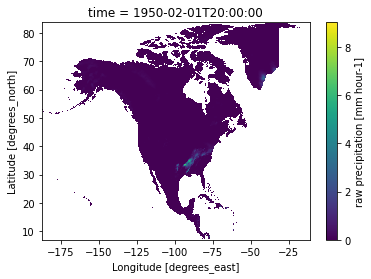

In [3]:
import xarray as xr

#ds = xr.open_dataset('../EM_Earth_v1/probabilistic_daily/prcp/Africa/195001/EM_Earth_probabilistic_daily_prcp_Africa_195001_025.nc')
#ds = xr.open_dataset('../EM_Earth_v1/deterministic_hourly/prcp/NorthAmerica/EM_Earth_deterministic_hourly_NorthAmerica_195001.nc')
#ds = xr.open_dataset('../EM_Earth_v1/deterministic_hourly_global/prcp/195001/EM_Earth_deterministic_hourly_prcp_global_195001.nc')
ds = xr.open_dataset('/Users/shg096/Downloads/EM_Earth_deterministic_hourly_NorthAmerica_195002.nc')

print(ds)


ds['prcp'][20,:,:].plot()
